In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from func import *
from torch.utils.data import random_split, TensorDataset
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_247358/1431605955.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
datos = pd.read_csv("Churn_Modelling.csv")
datos.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Separamos la ultima columna para que sea variable destino
datos_y = datos[datos.columns[-1]]

# Eliminamos las columnas que no funcionarán
datos_x = datos.drop(columns=["RowNumber", "CustomerId", "Surname", "Exited"])

# Convertimos en one hot encoding las columnas de genero y zona geográfica
datos_x = pd.get_dummies(datos_x)

In [4]:
escalador = StandardScaler()
datos_x = escalador.fit_transform(datos_x)

## train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size = 0.2, random_state = 2)

In [6]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
n_entradas = X_train.shape[1]

X Train: (8000, 13), X Test: (2000, 13), y_train: (8000,), y_test: (2000,)


## to tensor

In [7]:
t_X_train = torch.from_numpy(X_train).float().to("cpu") #MPS
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(y_train.values).float().to("cpu")
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]
test = TensorDataset(t_X_test, t_y_test)

In [8]:
%%time
lr = 0.001
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=13, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=200, bias=True)
  (linear5): Linear(in_features=200, out_features=8, bias=True)
  (linear6): Linear(in_features=8, out_features=1, bias=True)
)
Entranando el modelo

Epoch 100 	 Loss: 0.5096
Accuracy: 80.8499984741211

Epoch 200 	 Loss: 0.5096
Accuracy: 80.8499984741211

Epoch 300 	 Loss: 0.5094
Accuracy: 80.8499984741211

Epoch 400 	 Loss: 0.479
Accuracy: 80.8499984741211

Epoch 500 	 Loss: 0.4297
Accuracy: 80.44999694824219

Epoch 600 	 Loss: 0.4204
Accuracy: 80.8499984741211

Epoch 700 	 Loss: 0.3927
Accuracy: 82.3499984741211

Epoch 800 	 Loss: 0.3597
Accuracy: 84.4000015258789

Epoch 900 	 Loss: 0.3354
Accuracy: 85.75

Epoch 1000 	 Loss: 0.3279
Accuracy: 85.55000305175781

Epoch 1100 	 Loss: 0.3234
Accuracy: 84.800

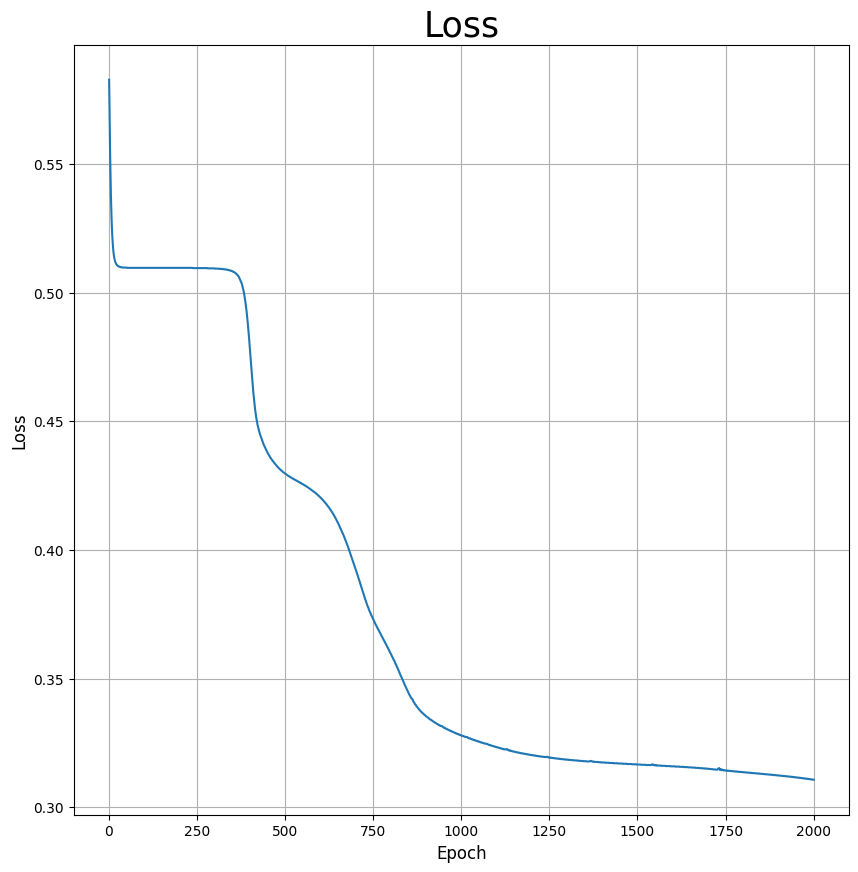

In [9]:



plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()



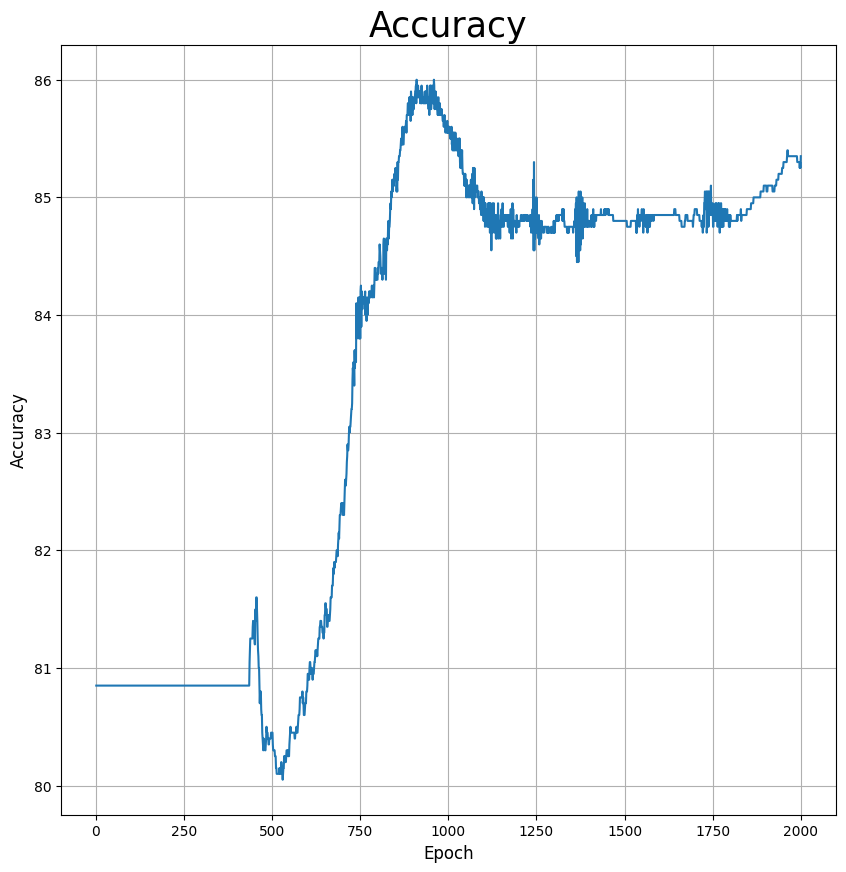

In [10]:


plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()



In [11]:


prediccion = model(t_X_test[5])
print(prediccion)



tensor([0.0196], grad_fn=<SigmoidBackward0>)
